This file loads a VAE and displays its reconstructions. 

In [3]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline  

import torch
import torch.nn as nn

import torch.optim as optim

import sys
sys.path.insert(0, '../')

import mnist_data_utils 
import mnist_vae_lib
import vae_training_lib

import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.nn.functional as f

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

sys.path.insert(0, '../../../rb_utils/')
sys.path.insert(0, '../../rb_utils/')
import common_utils 

In [4]:
np.random.seed(43534)
_ = torch.manual_seed(901)


# Load data

In [7]:
data_dir = '../mnist_data/'
propn_sample = 0.01

In [8]:
train_set, test_set = mnist_data_utils.get_moving_mnist_dataset(data_dir, propn_sample)

In [9]:
batchsize = 10

train_loader = torch.utils.data.DataLoader(
                 dataset=train_set,
                 batch_size=batchsize,
                 shuffle=True)

test_loader = torch.utils.data.DataLoader(
                dataset=test_set,
                batch_size=batchsize,
                shuffle=False)


In [10]:
len(train_loader.dataset)

600

In [11]:
for batch_idx, d in enumerate(train_loader):
    data_train = d
    break
    
for batch_idx, d in enumerate(test_loader):
    data_test = d
    break

In [12]:
slen = data_train['image'].shape[-1]

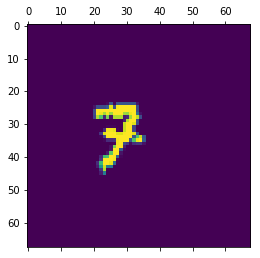

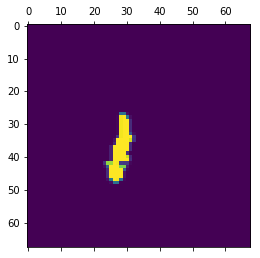

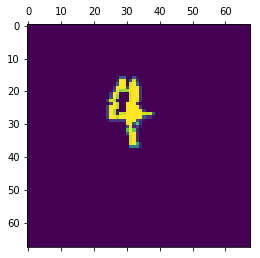

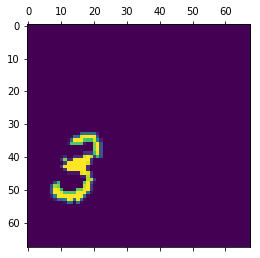

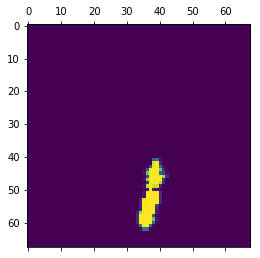

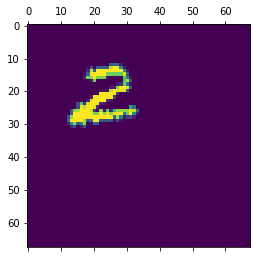

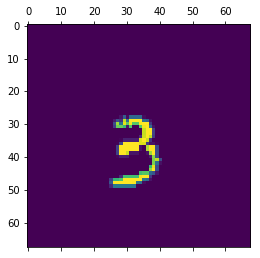

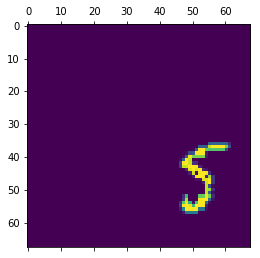

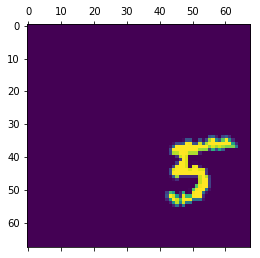

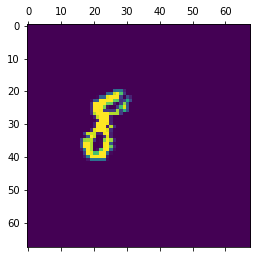

In [13]:
for i in range(batchsize): 
    plt.matshow(data_train['image'][i, 0, :, :])

In [18]:
image = data_train['image']
pixel_2d = data_train['pixel_2d']

# Define VAE

In [19]:
moving_mnist_vae = mnist_vae_lib.MovingHandwritingVAE()

In [20]:
vae_file = '../mnist_vae_results/moving_mnist_vae_reinforce_doublebs_topk5_final'

moving_mnist_vae.load_state_dict(torch.load(vae_file,
                               map_location=lambda storage, loc: storage))

moving_mnist_vae.eval()

MovingHandwritingVAE(
  (mnist_vae): HandwritingVAE(
    (encoder): MLPEncoder(
      (fc1): Linear(in_features=784, out_features=256, bias=True)
      (fc2): Linear(in_features=256, out_features=10, bias=True)
      (tanh): Tanh()
    )
    (decoder): MLPDecoder(
      (fc1): Linear(in_features=5, out_features=256, bias=True)
      (fc2): Linear(in_features=256, out_features=784, bias=True)
      (sigmoid): Sigmoid()
      (tanh): Tanh()
    )
  )
  (pixel_attention): PixelAttention(
    (attn): Sequential(
      (0): Conv2d(1, 7, kernel_size=(3, 3), stride=(1, 1))
      (1): ReLU()
      (2): Conv2d(7, 7, kernel_size=(3, 3), stride=(1, 1))
      (3): ReLU()
      (4): Conv2d(7, 7, kernel_size=(3, 3), stride=(1, 1))
      (5): ReLU()
      (6): Conv2d(7, 1, kernel_size=(3, 3), stride=(1, 1))
      (7): Flatten()
    )
    (fc1): Linear(in_features=3600, out_features=4624, bias=True)
    (log_softmax): LogSoftmax()
  )
)

# Check reconstructions 

In [23]:
log_pixel_probs = moving_mnist_vae.pixel_attention(image)

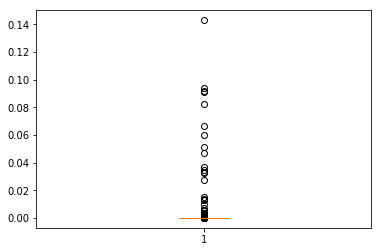

In [26]:
plt.boxplot(torch.exp(log_pixel_probs[6, :].detach())); 

In [27]:
map_pixel_1d = torch.argmax(log_pixel_probs, dim=1)

In [28]:
use_true_loc = True
if use_true_loc: 
    map_pixel_1d = moving_mnist_vae._pixel_1d_from_2d(pixel_2d)

pixel_one_hot = common_utils.get_one_hot_encoding_from_int(map_pixel_1d, slen**2)
recon_means = moving_mnist_vae.forward_cond_pixel_1d(pixel_one_hot, image)[0]

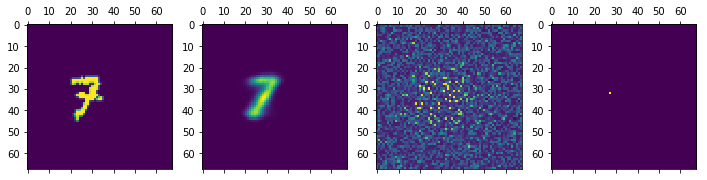

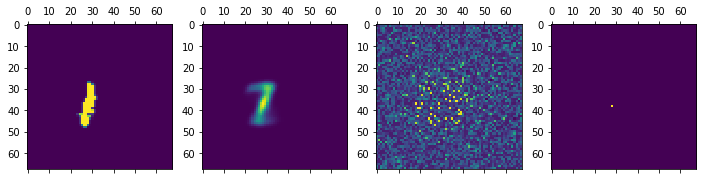

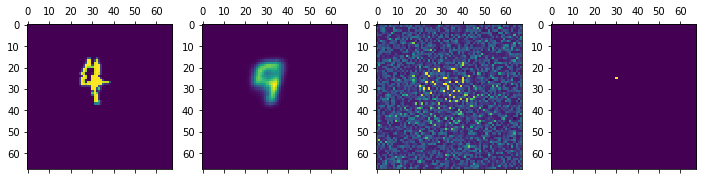

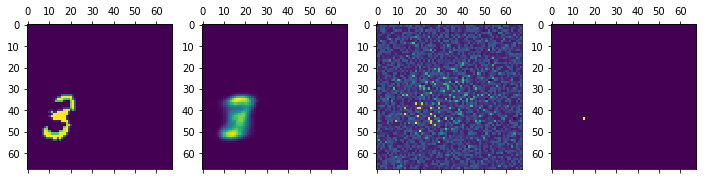

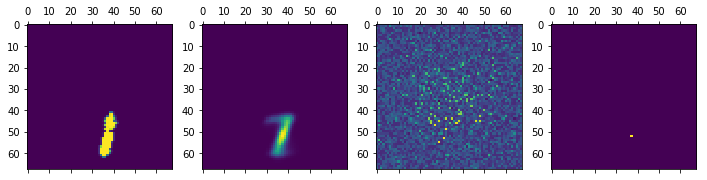

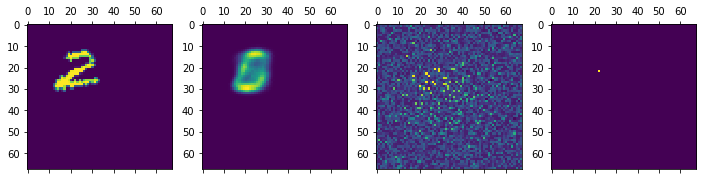

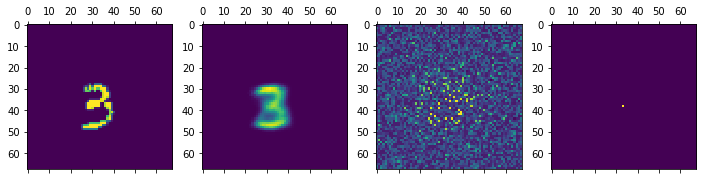

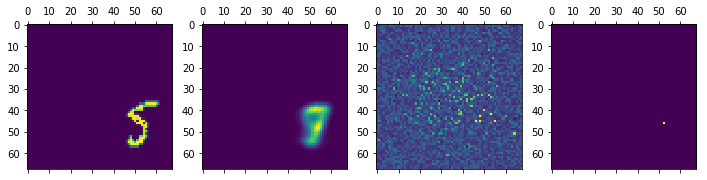

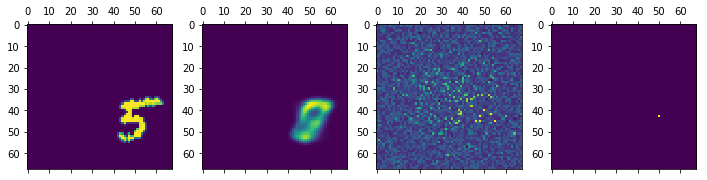

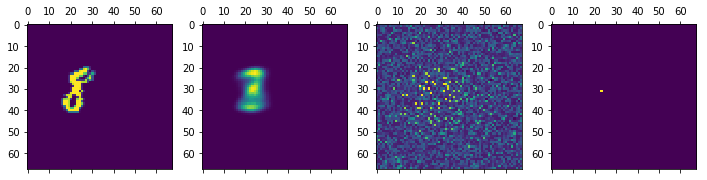

In [29]:
# printing the map locations 
loc_plots = torch.zeros(recon_means.shape)
map_pixel_2d = mnist_data_utils.pixel_1d_to_2d(sout = 68, padding = 0, pixel_1d = map_pixel_1d)

for i in range(0, 10): 
    
    _, axarr = plt.subplots(1, 4, figsize=(12, 12))
    
    # image and reconstruction 
    axarr[0].matshow(image[i, 0, :, :])
    axarr[1].matshow(recon_means[i, 0, :, :].detach())
    
    # location distributions 
    axarr[2].matshow(log_pixel_probs[i, :].view(68, 68).detach())
    
    # map location 
    loc_plots[i, 0, map_pixel_2d[i, 1], map_pixel_2d[i, 0]] = 1
    axarr[3].matshow(loc_plots[i, 0, :, :])